In [497]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sms
import statsmodels.api as sma
from sklearn.naive_bayes import MultinomialNB

In [504]:
with open('./test5.txt') as f:
    lines = f.readlines()

In [505]:
n, m = [int(i) for i in lines[0].split(' ')]
haps = [lines[i:i+3] for i in range(2, n * 3, 3)]
genos = [lines[i] for i in range(n * 3 + 2,  n * 3 + 2 + 2*m, 2)]
partial_genotypes = pd.Series(genos).apply(lambda g: pd.Series(list(g.strip()))).replace("?", np.NaN).astype(float)

def combine_haploids(hap, combine=True):
    a = pd.Series(list(hap[0].strip())).astype(int)
    b = pd.Series(list(hap[1].strip())).astype(int)
    if combine:
        return a + b
    else:
        return pd.concat([a, b], axis=1).T

known_genotypes = pd.Series(haps).apply(combine_haploids)
process_haploids = lambda h: combine_haploids(h, combine=False)
known_genotypes = pd.Series(haps).apply(combine_haploids)
known_haplotypes = pd.concat(pd.Series(haps).apply(process_haploids).values)
baseline = known_genotypes.mode()

<AxesSubplot:>

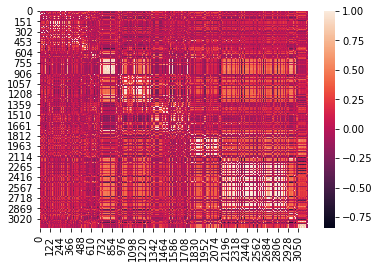

In [506]:
sns.heatmap(known_genotypes.corr())

In [507]:
corr = known_genotypes.corr()

def perfect_corr_value(i, corr, p):
    perfect_corrs = corr[i][corr[i] == 1]
    perfect_corr_values = p[p.index.isin(perfect_corrs.index)].value_counts()
    try:
        assert(len(perfect_corr_values) == 1) 
    except AssertionError:
        return None
    return perfect_corr_values.index[0]

p = partial_genotypes.loc[0]

def fill_perfect_corr(p):
    p_nas = p[p.isna()].reset_index()
    f = lambda i: perfect_corr_value(i, corr, p)
    p_nas[0] = p_nas['index'].apply(f)
    fills = p_nas.set_index('index')[0].dropna()
    p.loc[fills.index] = fills
    return p

part_filled_parital_genotypes = partial_genotypes.apply(fill_perfect_corr, axis=1)


In [514]:
part_filled_parital_genotypes.loc[13].isna().sum()
part_filled_parital_genotypes.loc[39].isna().sum()

845

In [508]:
na_indicies = part_filled_parital_genotypes.loc[0][part_filled_parital_genotypes.loc[0].isna()].index
for i in na_indicies:
    clf = MultinomialNB(fit_prior=True, alpha=0)
    X = known_genotypes.drop(i, axis=1)
    y = known_genotypes[i]
    clf.fit(X, y)
    X = partial_genotypes.drop(i, axis=1)
    X_clean = X.T.dropna().T
    df = pd.DataFrame(clf.feature_log_prob_.T)
    df = df[df.index.isin(X_clean.T.index)]
    jll = np.dot(X_clean, df)# + clf.class_log_prior_
    part_filled_parital_genotypes[i] =  pd.Series(clf.classes_[np.argmax(jll, axis=1)])

/Users/luke/projects/rosalind/.venv/lib/python3.9/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


ValueError: shapes (450,1974) and (1973,3) not aligned: 1974 (dim 1) != 1973 (dim 0)

In [510]:
i

13

In [ ]:
output = part_filled_parital_genotypes.fillna(0).astype(int).astype(str).apply(lambda row: "".join(row), axis=1)
with open('answer5.txt', "w") as f:
    output.apply(lambda line: f.write(line + "\n"))